# Titanic Survival Prediction
Pada kesempatan kali ini saya akan membangun model machine learning yang dapat memprediksi survived atau tidaknya seseorang dalam kasus kapal titanic. Oke, langsung saja kita mulai.

# Baseline
Always start with simple model (Emmanuel Ameisen, 2018).

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease

## Import Data

In [2]:
df = pd.read_csv("data/titanic.csv", index_col="PassengerId")
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.shape

(891, 11)

Data terdiri dari 891 baris dan 11 kolom.

In [4]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

Seluruh tipe data telah sesuai.

,missing_value,%
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,177,19.87
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,0,0.00
Cabin,687,77.10


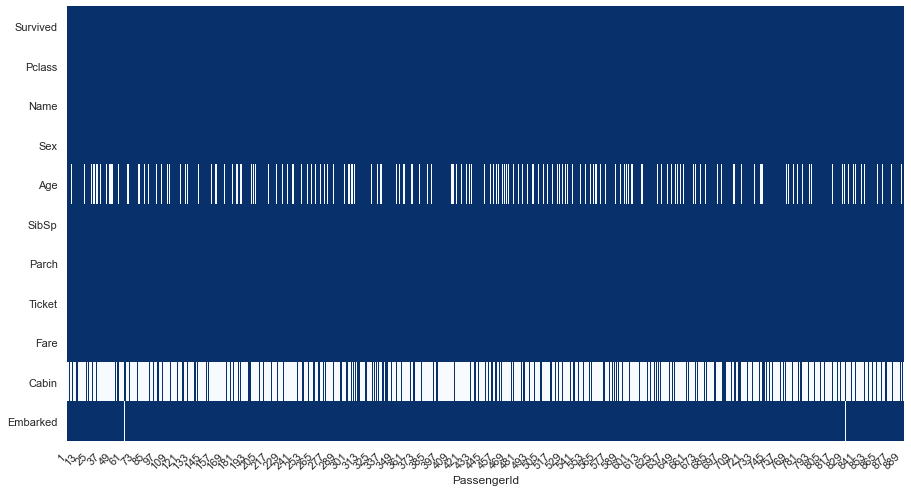

In [5]:
plot_missing_value(df, return_df=True)

In [6]:
df.drop(columns=['Cabin','Name','Ticket'], axis=1, inplace=True)

In [7]:
df.shape

(891, 8)

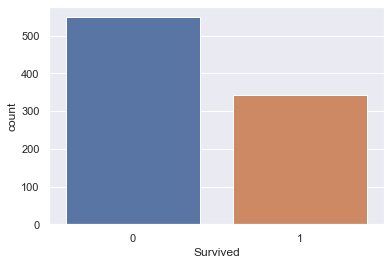

In [8]:
sns.countplot(df.Survived);

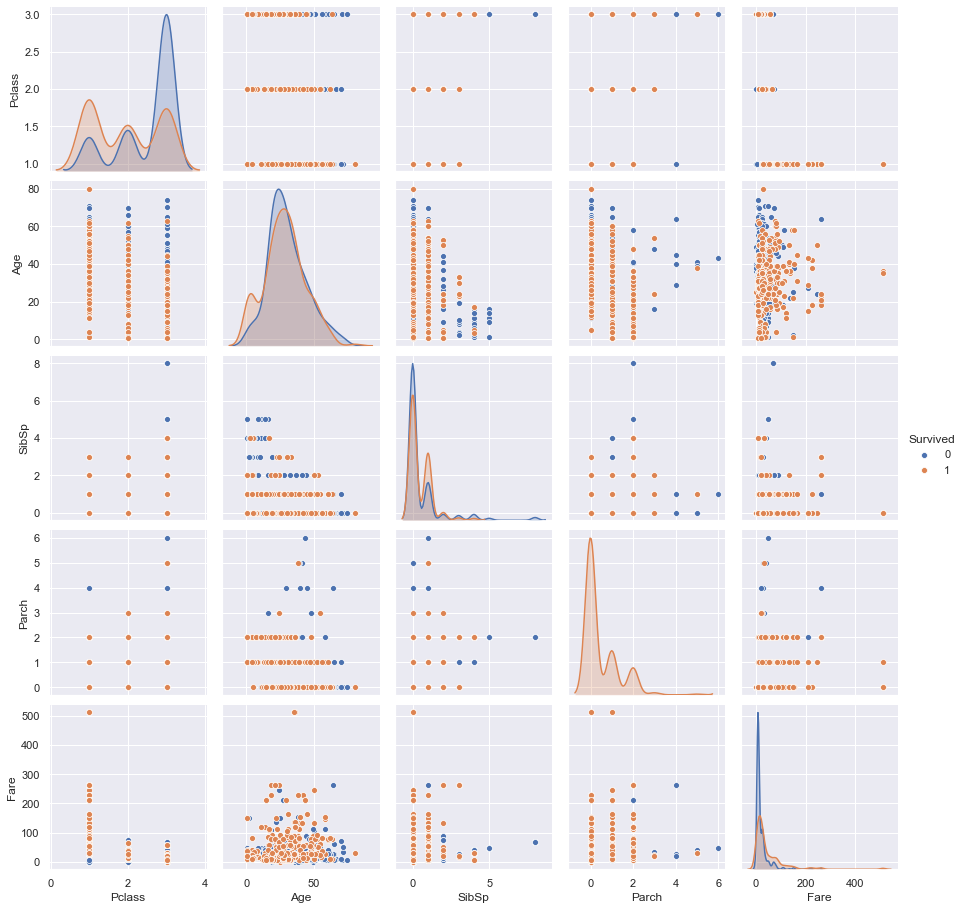

In [9]:
sns.pairplot(df, hue='Survived');

## Dataset Splitting

In [10]:
X = df.drop(columns="Survived")
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 7), (179, 7), (712,), (179,))

## Modeling

In [11]:
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from sklearn.linear_model import LogisticRegression

In [12]:
gsp.logreg_params

{'algo__fit_intercept': [True, False],
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [13]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
693,3,male,NaN,0,0,56.4958,S
482,2,male,NaN,0,0,0.0000,S
528,1,male,NaN,0,0,221.7792,S
856,3,female,18.0,0,1,9.3500,S
802,2,female,31.0,1,1,26.2500,S


In [14]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Age','SibSp','Parch','Fare']),
    ('categoric', cat_pipe(encoder='onehot'), ['Pclass','Sex','Embarked']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])


model = GridSearchCV(pipeline, gsp.logreg_params, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s


{'algo__C': 0.1, 'algo__fit_intercept': True}
0.8061797752808989 0.7992317541613316 0.8100558659217877


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    5.5s finished


Dari hasil baseline kita telah mendapatkan skor (akurasi) yang cukup bagus. 

In [15]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__C,param_algo__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.12480,9.536743e-08,0.01872,6.240058e-03,0.1,True,"{'algo__C': 0.1, 'algo__fit_intercept': True}",0.797203,0.748252,0.830986,0.809859,0.809859,0.799232,0.027703,1
8,0.13416,1.872003e-02,0.01560,9.536743e-08,10,True,"{'algo__C': 10.0, 'algo__fit_intercept': True}",0.790210,0.762238,0.802817,0.816901,0.816901,0.797813,0.020382,2
10,0.18912,2.526714e-02,0.02184,7.642489e-03,100,True,"{'algo__C': 100.0, 'algo__fit_intercept': True}",0.790210,0.762238,0.802817,0.816901,0.816901,0.797813,0.020382,2
11,0.12480,9.866285e-03,0.02184,7.642391e-03,100,False,"{'algo__C': 100.0, 'algo__fit_intercept': False}",0.790210,0.762238,0.802817,0.816901,0.816901,0.797813,0.020382,2
12,0.12168,6.239986e-03,0.01560,1.784161e-07,1000,True,"{'algo__C': 1000.0, 'algo__fit_intercept': True}",0.790210,0.762238,0.802817,0.816901,0.816901,0.797813,0.020382,2


## Evaluasi

In [16]:
from jcopml.plot import plot_confusion_matrix, plot_roc_curve, plot_classification_report

In [17]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       439
           1       0.78      0.69      0.73       273

    accuracy                           0.81       712
   macro avg       0.80      0.78      0.79       712
weighted avg       0.80      0.81      0.80       712


Test report
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       110
           1       0.81      0.67      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179



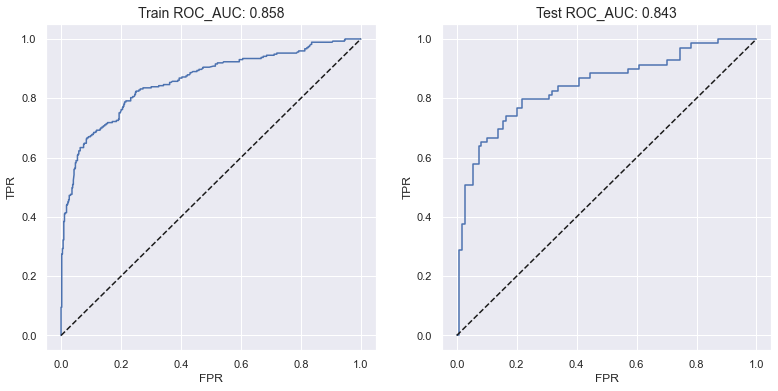

In [18]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

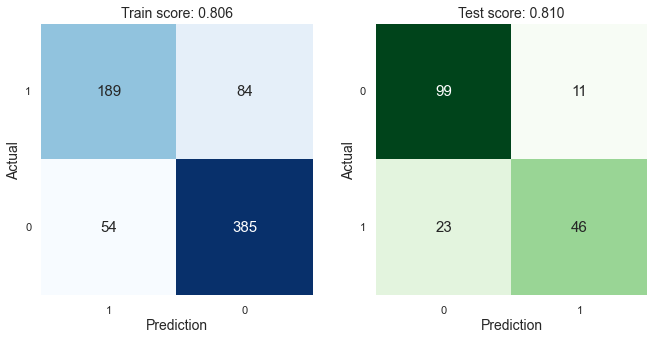

In [19]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

Paling banyak kesalahan prediksi terjadi pada prediksi tidak survived ternyata survived.

## Coba cek datanya

In [20]:
df_analisis = X_train.copy()
df_analisis['pred'] = model.predict(X_train)
df_analisis['actual'] = y_train.copy()
df_analisis.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,pred,actual
PassengerId,,,,,,,,,
693,3,male,NaN,0,0,56.4958,S,0,1
482,2,male,NaN,0,0,0.0000,S,0,0
528,1,male,NaN,0,0,221.7792,S,1,0
856,3,female,18.0,0,1,9.3500,S,1,1
802,2,female,31.0,1,1,26.2500,S,1,1


In [21]:
df_prec = df_analisis[(df_analisis.pred == 0) & (df_analisis.actual == 1)]
df_prec.head(20)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,pred,actual
PassengerId,,,,,,,,,
693,3,male,NaN,0,0,56.4958,S,0,1
510,3,male,26.00,0,0,56.4958,S,0,1
829,3,male,NaN,0,0,7.7500,Q,0,1
648,1,male,56.00,0,0,35.5000,C,0,1
227,2,male,19.00,0,0,10.5000,S,0,1
221,3,male,16.00,0,0,8.0500,S,0,1
431,1,male,28.00,0,0,26.5500,S,0,1
205,3,male,18.00,0,0,8.0500,S,0,1
108,3,male,NaN,0,0,7.7750,S,0,1


In [22]:
df_prec.Sex.value_counts()

male      78
female     6
Name: Sex, dtype: int64

In [23]:
df_prec.SibSp.value_counts()

0    53
1    25
2     3
4     2
3     1
Name: SibSp, dtype: int64

In [24]:
df_prec.Parch.value_counts()

0    64
1    13
2     5
5     1
3     1
Name: Parch, dtype: int64

In [25]:
df_recall = df_analisis[(df_analisis.pred == 1) & (df_analisis.actual == 0)]
df_recall

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,pred,actual
PassengerId,,,,,,,,,
528,1,male,NaN,0,0,221.7792,S,1,0
558,1,male,NaN,0,0,227.5250,C,1,0
403,3,female,21.0,1,0,9.8250,S,1,0
265,3,female,NaN,0,0,7.7500,Q,1,0
475,3,female,22.0,0,0,9.8375,S,1,0
206,3,female,2.0,0,1,10.4625,S,1,0
655,3,female,18.0,0,0,6.7500,Q,1,0
374,1,male,22.0,0,0,135.6333,C,1,0
416,3,female,NaN,0,0,8.0500,S,1,0


In [26]:
df_recall.Sex.value_counts()

female    44
male      10
Name: Sex, dtype: int64

In [27]:
df_recall.SibSp.value_counts()

0    33
1    15
3     3
2     2
4     1
Name: SibSp, dtype: int64

In [28]:
df_recall.Parch.value_counts()

0    35
1    10
2     8
5     1
Name: Parch, dtype: int64

Saya menangkap bahwa ada pola dimana male banyak diprediksi tidak survived sementara female banyak diprediksi survived. Mungkin akan coba kita visualisasikan.

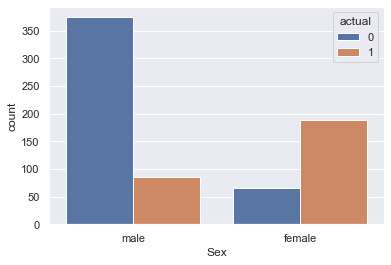

In [29]:
sns.countplot(df_analisis.Sex, hue='actual', data=df_analisis);

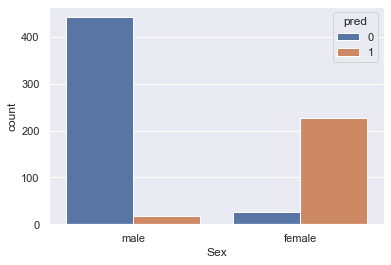

In [30]:
sns.countplot(df_analisis.Sex, hue='pred', data=df_analisis);

Sampai disini saya menarik kesimpulan bahwa model banyak memprediksi male sebagai tidak survived dan female sebagai survived. Oleh karena itu sepertinya kita membutuhkan tambahan fitur baru untuk membantu model agar dapat melakukan prediksi lebih baik lagi.

## Save Model

In [31]:
save_model(model.best_estimator_, "titanic_v1.pkl")

Model is pickled as model/titanic_v1.pkl
